# SD Traffic Analysis

Traffic is an issue that is part of everyone's everyday life. As UCSD students who lives commute to UC San Deigo every day, it is even more important for us to understand the traffic regulation within San Diego area. So we decided to analyze the traffic collision dataset maintained by city of San Diego police department. Since the dataset include variaties of dimentions, it allow us to make inferrences and build correlations among each others. We are hopeful that data sets like this one can be used to create safer and more efficient communities for everyone.


## Data Processing

Before we actually process the data, we need to important all libraries, packages, and models that we will utilize. 

In [ ]:
# import pandas & numpy library
import pandas as pd
import numpy as np

# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

# Statmodels & patsy
import patsy
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

Then we import our raw dataset. The data begins in January 2015 and is updated daily. Each row corresponds to a collision. Since this data is downloaded from San Diego police department, it’s very unlikely that there are errors. Below is a visualizations of some of the key fields:

In [ ]:
# read in data from csv
df = pd.read_csv('pd_collisions_datasd_v1.csv')
#show unclean data
df.head()

,report_id,date_time,police_beat,address_no_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
0,600096,2015-01-01 15:19:00,112,3600,,MT EVEREST,BOULEVARD,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,NaN
1,600068,2015-01-02 13:04:00,437,2800,S,WOODMAN,STREET,,,,21801A,VC,LEFT TURN YIELD UNTIL SAFE OR U-TURN,1,0,MISDEMEANOR
2,600051,2015-01-02 20:15:00,833,3800,,MENLO,AVENUE,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,0,0,MISDEMEANOR
3,600441,2015-01-13 13:59:00,611,3500,,MIDWAY,DRIVE,,,,82.22,MC,STOP UPON EMERGING FROM ALLEY/PRIVATE DRIVEWAY,1,0,NaN
4,171111,2015-01-14 20:00:00,835,4200,,JUNIPER,STREET,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR


# Data Cleaning


As with any data set, this one needs cleaning before starting any analysis. There are a few columns with only one value, reflecting the fact that all rows in this data correspond to traffic collisions.
We start by separating one column into several different columns with each informatino separated to make our analyzation easier. 


In [ ]:
#delete report_id police_beat address_no_primary address_pd_primary address_pd_intersecting 
# address_name_intersecting address_sfx_intersecting violation_section hit_run_1v1
df=df.drop(columns=['report_id','police_beat','address_no_primary','address_pd_primary','address_pd_intersecting','address_name_intersecting','address_sfx_intersecting','charge_desc','hit_run_lvl'])

#add new date_in_month column to store the month
df["date_in_month"]=df["date_time"].str[5:7]
df["date_in_month"]=df["date_in_month"].astype(int)

#add new date_in_month column to store the hour of the day
df["date_in_hour"]=df["date_time"].str[10:13]
df["date_in_hour"]=df["date_in_hour"].astype(int)

#add up injured+killed*3 new column named severity
#killed has higher weights in severity than injured so we times 3 in killed number
df["Severity"]=df["injured"]+df["killed"]*3
df=df.drop(columns=['injured','killed'])


We decided to use datapoints from 2018 to 2021 because we want to focuses more on recent years which are more applicable. 

In [ ]:
# only keep data that has date_time range from 2018 to 2021
list = ["2015","2016","2017","2022"]
for i in list:
    df = df[df["date_time"].str.contains(i) == False]

The next step is to check for null or missing values. We find out that there is one row in address_road_primary that has null datapoint. Since outdatasets contains huge amount of data, we decided to drop the whole row. 

In [ ]:
# check for null, we find out address_road_primary has one row of null, we choose to delete it
print('violation_section:',df['violation_section'].hasnans)
print('Severity:',df['Severity'].hasnans)
print('date_in_month:',df['date_in_month'].hasnans)
print('date_in_hour:',df['date_in_hour'].hasnans)
print('date_time:',df['date_time'].hasnans)
print('address_road_primary:',df['address_road_primary'].hasnans)
df[df['address_road_primary'].isnull()]
df=df.dropna(subset=['address_road_primary'])
print('address_road_primary:',df['address_road_primary'].hasnans)

violation_section: False
Severity: False
date_in_month: False
date_in_hour: False
date_time: False
address_road_primary: True
address_road_primary: False


Then we try to get a sense about how out dataset looks like:

In [ ]:
df.shape

(37148, 8)

We have in total 37149 data which corresponding to 37149 traffic collisions.

In [ ]:
#show clean data
df.head()

,date_time,address_road_primary,address_sfx_primary,violation_section,violation_type,date_in_month,date_in_hour,Severity
27906,2018-01-01 00:30:00,EL CAMINO DE TEATRO,,22350,VC,1,0,0
27907,2018-01-01 01:00:00,ROSECRANS,STREET,22350,VC,1,1,0
27908,2018-01-01 01:26:00,PALM,AVENUE,21954A,VC,1,1,3
27909,2018-01-01 02:05:00,LOGAN,AVENUE,22450(A),VC,1,2,0
27910,2018-01-01 02:26:00,DIVISION,STREET,22107,VC,1,2,0


In [ ]:
df.describe()

,date_in_month,date_in_hour,Severity
count,37148.000000,37148.000000,37148.000000
mean,6.600113,12.934398,0.591714
std,3.432761,6.455847,1.045014
min,1.000000,0.000000,0.000000
25%,4.000000,9.000000,0.000000
50%,7.000000,14.000000,0.000000
75%,10.000000,18.000000,1.000000
max,12.000000,23.000000,122.000000


## Data Exploration

###Collisions by Geography

First of all, since the data has multiple fields describing where a collision occurred. we decided to start out by looking at these fields. First, I’ll plot the distribution of collisions by area. As you can see from below, there are about 3978 streets in total. Instead of looking at the ditribution of all streets, we decided to look at the distribution for top 20 streets that has greater amount of collisions.

In [ ]:
streets = df['address_road_primary'].unique()
print(streets)
print(len(streets))

['EL CAMINO DE TEATRO' 'ROSECRANS' 'PALM' ... 'WORTHING' 'THRONE'
 'OF CURBLINE 1900 CYPRESS']
3977


count    20.000000
mean      0.011045
std       0.004888
min       0.006003
25%       0.007928
50%       0.010593
75%       0.011528
max       0.024766
Name: address_road_primary, dtype: float64

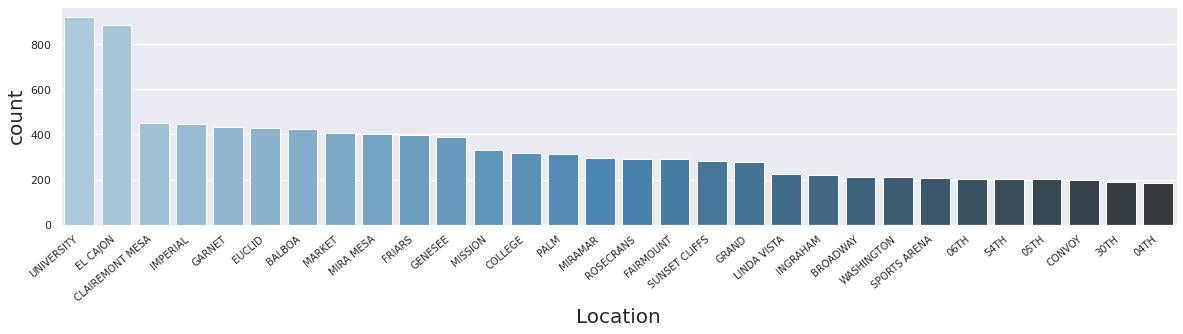

In [ ]:
top_20 = pd.DataFrame(df['address_road_primary'].value_counts()).reset_index().head(30)
plot1 = sns.barplot(data=top_20, x='index', y='address_road_primary', palette='Blues_d')
plot1.set_xticklabels(plot1.get_xticklabels(), rotation=40, ha="right" ,fontsize=10)
plot1.set_xlabel("Location", fontsize = 20)
plot1.set_ylabel("count", fontsize = 20)

top_20_pecentage['address_road_primary'].describe()

As we can see from the graph, both University street and ElCajon have very high collision rates, so we need to look into those two stree by plotting the overall distribution traffic collisions over time. 

(1.0, 6.0)

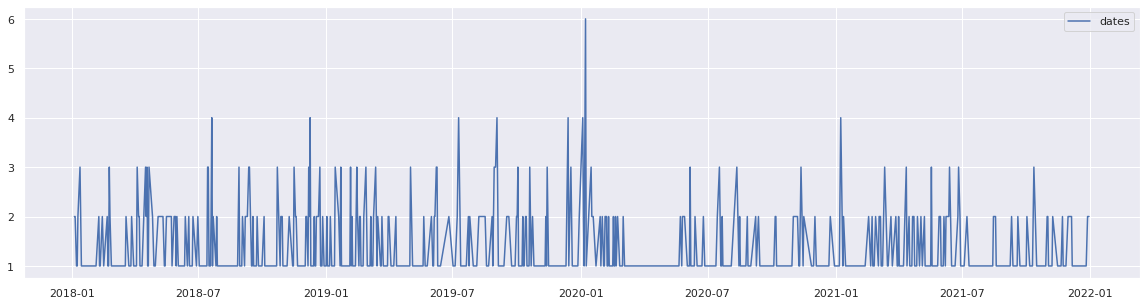

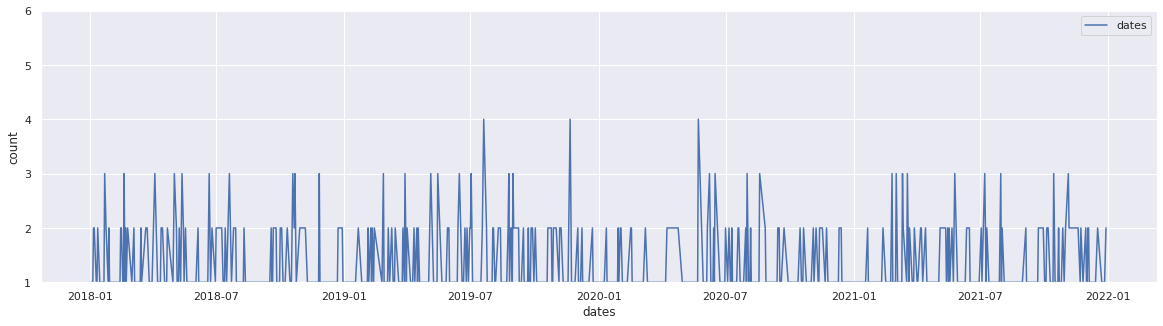

In [ ]:
# create a data frame that only contains university avenue 
df_sub1 = df[(df['address_road_primary'] == 'UNIVERSITY')]
time_info = pd.to_datetime(df_sub1['date_time'], format='%Y-%m-%d %H:%M:%S')

#fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 6))

# add 3 new columns to the dataFrame
df_sub1['dates'] = pd.DatetimeIndex(time_info).date

# df_time['date'].apply()
# df_time['count'] = university['dates'].value_counts()
# df_time = df_time.merge(map, how='outer',left_on = 'date', right_on='index')
# df_time['dates'] = df_time['dates'].fillna(0)
# pd.to_datetime(map['index'])
# sns.lineplot(data=map, x='index', y='dates')

sns.set(rc = {'figure.figsize':(20,5)})
map = df_sub1['dates'].value_counts().to_frame()
map.plot(label='dates')

# create a data frame that only contains EL CAJON avenue 
EL = df[df['address_road_primary'] == 'EL CAJON']
time_info2 = pd.to_datetime(EL['date_time'], format='%Y-%m-%d %H:%M:%S')

# add 3 new columns to the dataFrame
EL['dates'] = pd.DatetimeIndex(time_info2).date

sns.set(rc = {'figure.figsize':(20,5)})
map2 = EL['dates'].value_counts().to_frame()
map2.plot(label='dates')

plt.xlabel("dates")
plt.ylabel("count")
plt.ylim(1, 6)

The trend for both graph are similar but the overall, the amount of collisions for university avenue is greater than El Cajon street. Also there is a gap between 2020-01 to 2020-07 for which means that there are no traffic collisions in this period. This is unusual, we may need to look into these data and figure out why. (unfinished)

This it the trend of all collosions happended between 2018 to 2021 for universtiy avenue

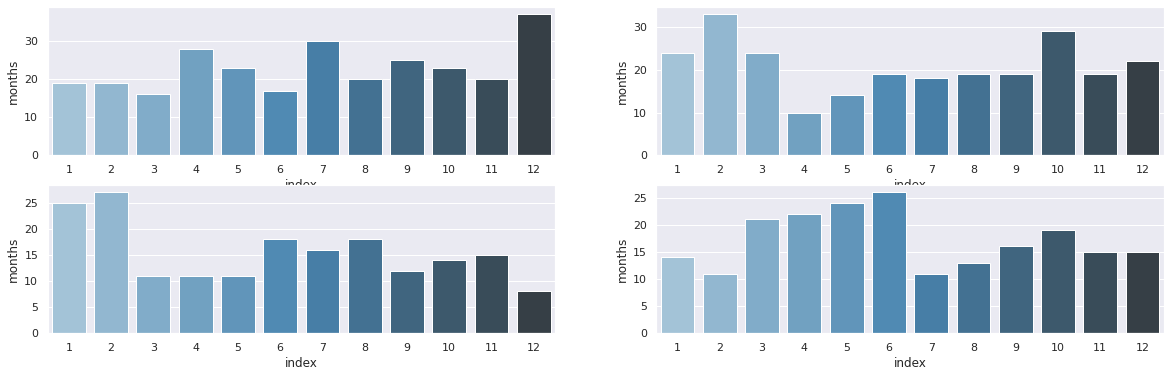

In [ ]:

# daily collision in different years 2018, 2019, 2020, 2021
uni2018 = pd.DataFrame((university[university['years'] == 2018])['months'].value_counts()).reset_index()
uni2019 = pd.DataFrame((university[university['years'] == 2019])['months'].value_counts()).reset_index()
uni2020 = pd.DataFrame((university[university['years'] == 2020])['months'].value_counts()).reset_index()
uni2021 = pd.DataFrame((university[university['years'] == 2021])['months'].value_counts()).reset_index()
# plot 2018 daily collision datasets
f1 = sns.barplot(data=uni2018, x='index', y='months', palette='Blues_d', ax=axs[0][0])
f2 = sns.barplot(data=uni2019, x='index', y='months', palette='Blues_d', ax=axs[0][1])
f3 = sns.barplot(data=uni2020, x='index', y='months', palette='Blues_d', ax=axs[1][0])
f4 = sns.barplot(data=uni2021, x='index', y='months', palette='Blues_d', ax=axs[1][1])

# f4 = sns.countplot(data=university, x='months', palette='Blues_d', ax=axs[1][0])
# the distribution of collision over time (day)
# f3 = sns.countplot(data=university, x='years', palette='Blues_d', ax=axs[1][1])

# Analysis with severity

We have already look at the relationship between car collision and date. However, not every car collsion has the same severity. Some car collisions are more severe, with more injuried and killed people, while some are less severe with no one injuried or killed. As a result, it's important to take severity into account. Previously in the data cleaning part we have already calculated the severity based on injuried and killed number. Now we want to see if the car collisions with high severity have tendency to appear in particular time.

Text(0, 0.5, 'number of times happened with high severe car collisions')

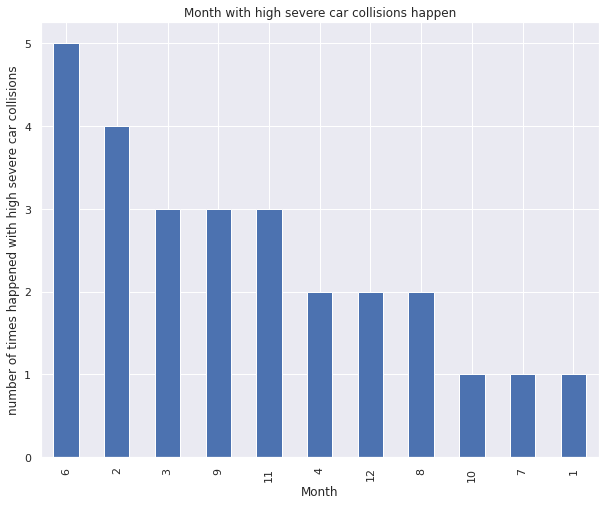

In [ ]:
df_sortBySev=df.sort_values(by=['Severity'],ascending=False)
df_sortBySevTop=df_sortBySev.loc[df["Severity"]>6]
df_sortBySevTop
# we consider the car collision with severity 122 to be an invalid data, remove from df_sortBySevTop
df_sortBySevTop=df_sortBySevTop.loc[df["Severity"]<100]
df_SevInMonth=df_sortBySevTop["date_in_month"].value_counts()
df_SevInMonth.plot(kind='bar',figsize=(10,8))
plt.title('Month with high severe car collisions happen')
plt.xlabel('Month')
plt.ylabel('number of times happened with high severe car collisions')

From this barplot we can see that June havs highest number of times happened with high severe car collisions. This is reasonable because June is the beginning of summer, and people tend to start traveling to enjoy the nice summer.

Text(0, 0.5, 'number of times happened with high severe car collisions')

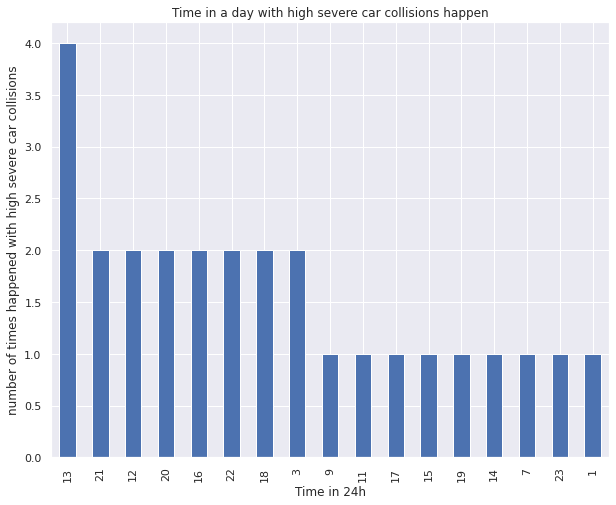

In [ ]:
df_SevInHour=df_sortBySevTop["date_in_hour"].value_counts()
df_SevInHour.plot(kind='bar',figsize=(10,8))
plt.title('Time in a day with high severe car collisions happen')
plt.xlabel('Time in 24h')
plt.ylabel('number of times happened with high severe car collisions')

From this barplot, we can see that severe accidents peaked on 1pm and also peaked between 7pm-10pm.

Text(0, 0.5, 'number of times happened with high severe car collisions')

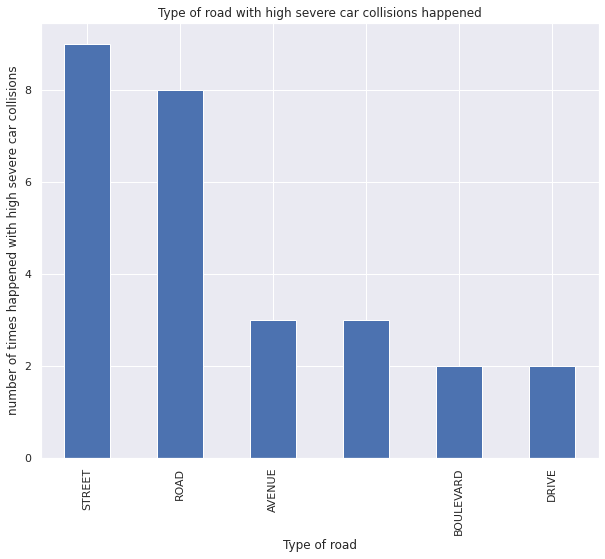

In [ ]:
df_Add=df_sortBySevTop['address_sfx_primary'].value_counts()
df_Add.plot(kind='bar',figsize=(10,8))
plt.title('Type of road with high severe car collisions happened')
plt.xlabel('Type of road')
plt.ylabel('number of times happened with high severe car collisions')

From this barplot we can clearly see that Boulevard (Blvd) and Drive (Dr.) have less number of times in which severe car collisions happen. This is reasonable because according to the road naming convention, Boulevard (Blvd) is an extremely wide street, often with vegetation on either side and a median splitting up the lanes of traffic. Drive (Dr.)is a long, winding road with a route shaped by bodies of water, mountains, or other geography. Blvd and Dr. are wider than the Street and road, so less number of high severe car collisions happen in Blvd and Dr. (Reference:https://www.urbo.com/content/heres-the-difference-between-streets-boulevards-avenues-and-other-roads/)

### **Analysis between severity and day, month, hour**

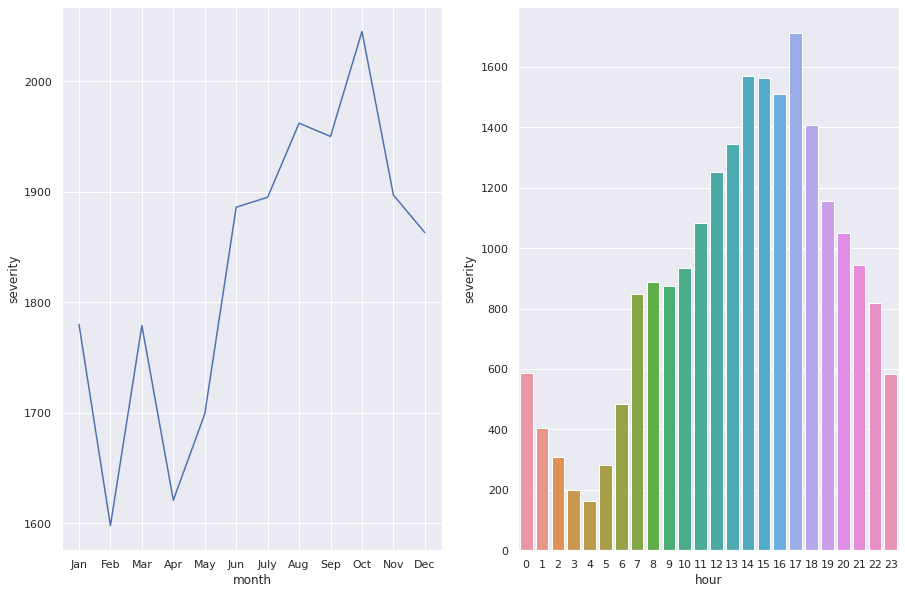

In [ ]:
fig,axs = plt.subplots(nrows = 1,ncols =2, figsize =(15,10))
# anlysis severity in each month
month = 1
total_month = []
while(month <=12):
    total_month.append(df.loc[df['date_in_month'] == month, 'Severity'].sum())
    month= month + 1
m_data = {'month': ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec'], 'severity': total_month}
month_anlysis = pd.DataFrame(data=m_data)
sns.lineplot(x = 'month', y ='severity',data = month_anlysis,ax=axs[0],palette ='Reds')

# anlysis severity in each hour
total_hour = []
each_hour = []
hour = 0
while(hour <=23):
    total_hour.append(df.loc[df['date_in_hour']== hour,'Severity'].sum())
    each_hour.append(hour)
    hour = hour+1
h_data = {'hour': each_hour, 'severity': total_hour}
hour_anlysis = pd.DataFrame(data=h_data)
sns.barplot(x = 'hour', y ='severity',data = hour_anlysis,ax=axs[1])

# New Section

Above we compare the serverity point with month and hour seperately. As we see from above visualization, Serverity point reaches to the maximum when it is 17:00. We suspect this is because 17:00 is most of people driving back to home from business or school.So this may cause traffic jam and therefore more likely to cause traffic collision and the damage traffic collision brings are the max at this time. In addition we can also see the severity are very low during 2am - 5am, since lots of people are sleeping during that time. In terms of month, the severity reachs to the max when it is october. November,December, and summer also have high severity. Since most of the holiday are concentrate at that time and summer is student's break. So we suspect that most of students and their family will travel which cause the severity point be higher.

[Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Sunday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Monday')]

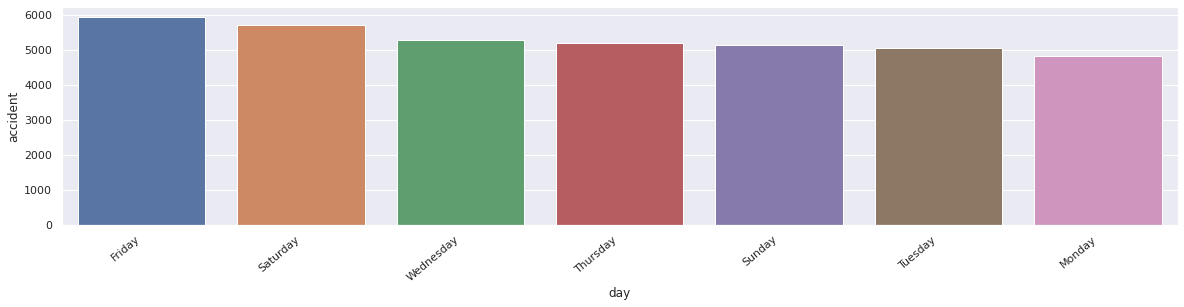

In [ ]:
#anlysis severity in day
df["date_in_day"]=df["date_time"].str[:10]
day = []
for i in df['date_in_day']:
    temp = pd.Timestamp(i)
    name=temp.day_name()
    day.append(name)
some = pd.Index(day)
count=some.value_counts()
daytime=count.index.tolist()
number = count.values.tolist()
d_data = {'day': daytime, 'accident': number}
day_anlysis = pd.DataFrame(data=d_data)
day_plot=sns.barplot(x = 'day', y ='accident',data = day_anlysis)
day_plot.set_xticklabels(day_plot.get_xticklabels(), rotation=40, ha="right")


From the plot above we can see that Friday and Saturday are the two most day which accidents happen the most. We suspect it is because weekends and most people wants to hang out. and the reason which sunday are not that much may because most people choose to take break on Sunday after hanging out on Friday and Saturday in order to get ready for Monday.

Find the top 10 violation section first



In [ ]:
df["violation_section"].value_counts().nlargest(10)

22107       8774
MISC-HAZ    7280
22350       4618
22106       2278
21453A      1882
20002(A)    1460
23152A      1172
21703       1148
21801A       774
21804        701
Name: violation_section, dtype: int64

In [ ]:
df['violation_section'].value_counts()[:10].index.tolist()
df_10 = df.loc[df['violation_section'].isin(['22107',
 'MISC-HAZ',
 '22350',
 '22106',
 '21453A',
 '21703',
 '20002(A)',
 '21801A',
 '23152A',
 '21804'])]
df_10

,date_time,address_road_primary,address_sfx_primary,violation_section,violation_type,date_in_month,date_in_hour,Severity,date_in_day
28684,2018-01-01 00:30:00,EL CAMINO DE TEATRO,,22350,VC,1,0,0,2018-01-01
28685,2018-01-01 01:00:00,ROSECRANS,STREET,22350,VC,1,1,0,2018-01-01
28688,2018-01-01 02:26:00,DIVISION,STREET,22107,VC,1,2,0,2018-01-01
28689,2018-01-01 03:10:00,GESNER,STREET,22107,VC,1,3,0,2018-01-01
28690,2018-01-01 03:13:00,CLAIREMONT,DRIVE,22107,VC,1,3,3,2018-01-01
...,...,...,...,...,...,...,...,...,...
65821,2021-12-31 16:00:00,SIMS,ROAD,22106,VC,12,16,1,2021-12-31
65823,2021-12-31 17:40:00,COLLEGE,AVENUE,MISC-HAZ,VC,12,17,0,2021-12-31
65824,2021-12-31 18:00:00,SAN YSIDRO,BOULEVARD,20002(A),VC,12,18,0,2021-12-31
65827,2021-12-31 20:23:18,HAWTHORN,STREET,22350,VC,12,20,1,2021-12-31


We translate the code of violation section into its type

In [ ]:
df_10['violation_section'].replace({'22107':"lane change",
 'MISC-HAZ':"Miscellaneous Driving Hazards",
 '22350':"highway speeding",
 '22106':"highway stop",
 '21453A':"redlight no stop",
 '21703':"Tailgaiting",
 '20002(A)':"misdemeanor hit and run",
 '21801A':"Not yielding when turning",
 '23152A':"drunk",
 '21804':"Improper Merge"},inplace=True)
df_10

,date_time,address_road_primary,address_sfx_primary,violation_section,violation_type,date_in_month,date_in_hour,Severity,date_in_day
28684,2018-01-01 00:30:00,EL CAMINO DE TEATRO,,highway speeding,VC,1,0,0,2018-01-01
28685,2018-01-01 01:00:00,ROSECRANS,STREET,highway speeding,VC,1,1,0,2018-01-01
28688,2018-01-01 02:26:00,DIVISION,STREET,lane change,VC,1,2,0,2018-01-01
28689,2018-01-01 03:10:00,GESNER,STREET,lane change,VC,1,3,0,2018-01-01
28690,2018-01-01 03:13:00,CLAIREMONT,DRIVE,lane change,VC,1,3,3,2018-01-01
...,...,...,...,...,...,...,...,...,...
65821,2021-12-31 16:00:00,SIMS,ROAD,highway stop,VC,12,16,1,2021-12-31
65823,2021-12-31 17:40:00,COLLEGE,AVENUE,Miscellaneous Driving Hazards,VC,12,17,0,2021-12-31
65824,2021-12-31 18:00:00,SAN YSIDRO,BOULEVARD,misdemeanor hit and run,VC,12,18,0,2021-12-31
65827,2021-12-31 20:23:18,HAWTHORN,STREET,highway speeding,VC,12,20,1,2021-12-31


Display the most common violation type in San Diego

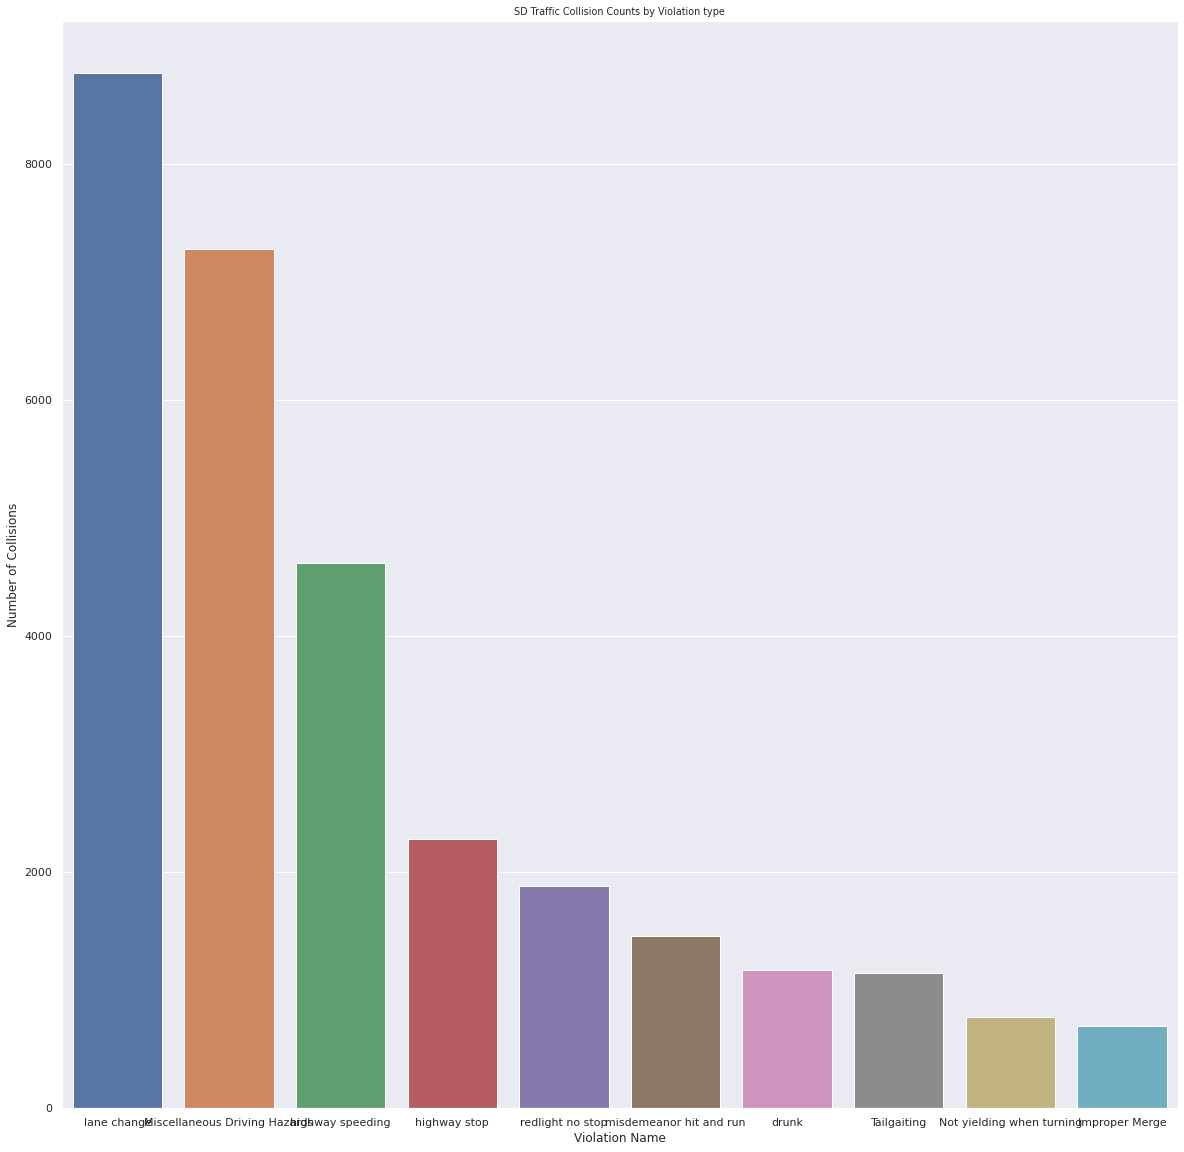

In [ ]:
charge_type_df = pd.DataFrame(df_10['violation_section'].value_counts())
viosec_df = pd.DataFrame(df_10['violation_section'].value_counts())
viosec_df_top = charge_type_df 
plt.figure(figsize=(20,20))
ax1 = sns.barplot(data=viosec_df_top, x=viosec_df_top.index, y='violation_section')

sns.set_context("paper")
plt.title('SD Traffic Collision Counts by Violation type')
plt.xlabel('Violation Name')
plt.ylabel('Number of Collisions')
plt.show()


We are interested in which kind of violation result in most serious severity

In [ ]:

number_violations = df_10.violation_section.unique()
totalViolations = []

# Count each  violation
for violation in number_violations:
    Severity_vio_df = df_10[df_10.violation_section==violation]
    totalViolations.append((violation, sum(Severity_vio_df.Severity)))
    
# Sort and determine violations by Severity
top10_vio_sort_Severity = sorted(totalViolations, key=lambda tup: tup[1], reverse = True)
top10vio_Severity_df = pd.DataFrame(data=top10_vio_sort_Severity, columns = ['violation','Severity'])
top10vio_Severity_df

,violation,Severity
0,highway speeding,3833
1,lane change,3354
2,redlight no stop,2646
3,Miscellaneous Driving Hazards,1792
4,Not yielding when turning,1042
5,Tailgaiting,1039
6,Improper Merge,801
7,drunk,488
8,highway stop,455
9,misdemeanor hit and run,216


# predections


We're trying to observe if we could use the information in date_time to predict a severity of a collision

First, we need to get year and month from date_time and we did so by creating a new dataframe called dfPredict from df

In [ ]:
import datetime
dfPredict = df
dfPredict['year'] = pd.DatetimeIndex(df['date_time']).year
dfPredict['month'] = pd.DatetimeIndex(df['date_time']).month
dfPredict

Then we converted the date_time to one hot encoding for easier analysis of categorical variables in the future

In [ ]:
from sklearn.preprocessing import OneHotEncoder

### One hot encoding on years
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(dfPredict[['year']]).toarray())
adr = dfPredict.year.unique()
encoder_df.columns = adr
dfPredict = dfPredict.reset_index()
dfPredict = pd.concat([dfPredict, encoder_df], axis=1)

### One hot encoding on months
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(dfPredict[['month']]).toarray())
adr = dfPredict.month.unique()
encoder_df.columns = adr
dfPredict = pd.concat([dfPredict, encoder_df], axis=1)

dfPredict

We tried to split the data into training and testing sets and use machine learning method(logistic regression) to train the model. However, as we can see from the results, we got a relatively low score from out model, which means out model is not good at predicting severity from year and month

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = np.array(dfPredict.iloc[:,-16:])
y = np.array(dfPredict['Severity'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
LR = LogisticRegression().fit(X_train, y_train)
LR.score(X_test,y_test)

In [ ]:
outcome, predictors = patsy.dmatrices('Severity ~ month+year', dfPredict)
model = sm.OLS(outcome, predictors)
res_1 = model.fit()
print(res_1.summary())

We can tell that the p value is low and slope is also non-zero for the OLS of Severity with both month and year from running OLS, which means there's a relationship between both months and years on Severity of collisions. However this relationship may not be very strong and thus not be able to be used to predict Serverity of collisions
